In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_ds = pd.read_csv('train_set.csv')
print(f"Length train set: {len(train_ds)}")
test_ds = pd.read_csv('test_set.csv')
print(f"Length test set: {len(test_ds)}")

Length train set: 1752
Length test set: 439


In [3]:
train_ds.groupby(['Label']).count()

,Job_offer
Label,
Java Developer,364
Programmer,380
Software Engineer,301
System Analyst,295
Web Developer,412


In [4]:
test_ds.groupby(['Label']).count()

,Job_offer
Label,
Java Developer,91
Programmer,96
Software Engineer,75
System Analyst,74
Web Developer,103


In [20]:
import sys
!conda install --yes --prefix {sys.prefix} numpy

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: spacy download en


In [37]:
!python -m spacy download en_core_web_md

^C


In [123]:
import re
import nltk
from nltk.corpus import stopwords as sw
import spacy
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

#Download if needed
#nltk.download('stopwords')
stop_words = sw.words('italian')
stop_words_eng = sw.words('english')
stop_words_de = sw.words('german')

commonverbs = list(pd.read_csv('commonverbs.csv',header=None).values[0])

frequent = list(pd.read_csv('frequentwords.csv',header=None).values[0])
# frequent = []

include_words = ['bene','bel','buon']
for i in include_words:
    if i in stop_words:
        stop_words.remove(i)


stop_words=stop_words+stop_words_eng+stop_words_de+frequent+commonverbs
stop_words = set(stop_words)
include_words = set(include_words)

#it_core_news_sm, md, lg
lemmatizer = spacy.load("it_core_news_lg", disable=[])#"tokenizer","tagger", "parser", "ner", "textcat"
def CleanSentence(sentence,sw=stop_words):
    sentence = sentence.lower()
    sentence = re.sub("`!@#$%^&*()_+-\{}|;'':,./<>?", " ", sentence)
    sentence = re.sub("(\\d|\\W)+", " ", sentence)
    
    lemmas = lemmatizer(sentence)
    newSentence = ""
    removed_s = []
    removed_c = []
    min = 3
    max = 12
    for lemma in lemmas:
        word = lemma.lemma_
        if word not in stop_words:
            if  (min <= len(word) <= max or word in include_words):
                newSentence = newSentence + word + " "
            else:
                removed_c.append(word)
        else:
            removed_s.append(word)
    if(False):
        print(removed_s)
        if(len(removed_c)>0):
            print()
            print(removed_c)
            print("--- ---- ----")
    return newSentence

def CleanText(text):
    sentences = []
    for row in text:
        sentences.append((CleanSentence(row)))
    
    return sentences

In [125]:
train_ds['clean'] = CleanText(train_ds['Job_offer'])
test_ds['clean'] = CleanText(test_ds['Job_offer'])

In [20]:
ind = 123

In [30]:
train_ds['Job_offer'][ind]

"Lavora a scuola con ottima retribuzione\n     * LA RISORSA UMANA.IT SRL Divisione Recruitment ricerca Per rinomata azienda settore packaging food e beverage, UN PROGETTISTA SOFTWARE AUTOMATION CON ESPERIENZA (PLC, HMI, Motion, Sistemi di Visione e Robotica).\n       La risorsa si occuperà di:\n       - definire la struttura e le caratteristiche dell'Hardware del progetto (PLC ed HMI, Motion, Supervisioni di impianto, Safety)\n       - progettare il Software macchina utilizzando gli applicativi\n       - svolgere analisi preliminare e correzione del Software (Debug iniziale) attraverso l'utilizzo di applicativi di simulazione (simulatori di CPU e simulatori di HMI).\n       - installare presso il cliente il software progettato (circa 40 giorni spalmati nell'anno)\n       - test I/O e prove e simulazioni del Software macchina con collaudo funzionale della macchina."

In [126]:
train_ds['clean'][ind]

'scuola ottimo retribuzione risorsa srl divisione recruitment rinomato azienda settore packaging food beverage progettista software automation esperienza plc hmi motion sistemare visione robotico risorsa definire strutturare hardware progettare plc hmi motion supervisione impiantire safety progettare software applicativo analisi preliminare correzione software debug iniziale applicativo simulazione simulatore cpu simulatore hmi installare cliente software progettare circa spalmare test prova simulazione software collaudare funzionale '

In [34]:
train_ds['clean'][ind]

'scuola ottimo retribuzione risorsa umano srl divisione recruitment rinomato azienda settore packaging food beverage progettista software automation esperienza plc hmi motion sistemare visione robotico risorsa definire strutturare hardware progettare plc hmi motion supervisione impiantire safety progettare software macchinare applicativo analisi preliminare correzione software debug iniziale applicativo simulazione simulatore cpu simulatore hmi installare pressare cliente software progettare circa giorno spalmare test prova simulazione software macchinare collaudare funzionale macchinare '

In [127]:
counter_text = []
words_text = {}
ds = train_ds['clean']
for s in ds:
    counter_text.append(len(s.split()))
    for w in s.split():
        if w not in words_text:
            words_text[w] = 1
        words_text[w] = words_text[w] + 1
print(f'Different words in training: {len(words_text)}')

Different words in training: 4954


In [122]:
print({k: v for k, v in sorted(words_text.items(), key=lambda item: item[1])})

{'convolte': 2, 'perito': 2, 'mvvm': 2, 'webdev': 2, 'import': 2, 'export': 2, 'collaborarai': 2, 'timing': 2, 'contract': 2, 'chiaramente': 2, 'likely': 2, 'includes': 2, 'suddetto': 2, 'œregolamento': 2, 'personaliâ': 2, 'prog': 2, 'mondosi': 2, 'elementor': 2, 'wbsadmin': 2, 'sansepolcro': 2, 'valtiberina': 2, 'paradigms': 2, 'elastic': 2, 'clion': 2, 'srlsi': 2, 'rivolgendosi': 2, 'anti': 2, 'predisposto': 2, 'databases': 2, 'cooperjob': 2, 'planet': 2, 'normalmente': 2, 'cda': 2, 'rilevazione': 2, 'ventilazione': 2, 'dashboard': 2, 'basandosi': 2, 'predittive': 2, 'budapest': 2, 'altavilla': 2, 'spac': 2, 'jave': 2, 'obbiettare': 2, 'young': 2, 'even': 2, 'recent': 2, 'graduato': 2, 'wants': 2, 'challenging': 2, 'lucrare': 2, 'patronato': 2, 'presidente': 2, 'repubblica': 2, 'volontariato': 2, 'essa': 2, 'diversamente': 2, 'volontario': 2, 'ausiliario': 2, 'umanitario': 2, 'comitato': 2, 'cicr': 2, 'federazione': 2, 'ficr': 2, 'concorso': 2, 'benchmark': 2, 'pervenire': 2, 'agosto

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams

#'clean', 'Job_offer'
column = 'clean'
max_feature = len(train_ds[column])
# print(f'#Feature {max_feature}')

def X_tfidf(sentences,max_feature = max_feature):  
    tfidf = TfidfVectorizer(min_df=2, max_df=0.999, ngram_range=(1,3),lowercase=True)#,strip_accents='ascii'
    X = tfidf.fit_transform(sentences)
    return X, tfidf

train_vec, vectorizer = X_tfidf(train_ds[column])
# test_vec, vectorizer = X_tfidf(test_ds['clean'])
test_vec = vectorizer.transform(test_ds[column])

# X_train, X_test, y_train, y_test = train_ds['clean'], test_ds['clean'], train_ds['Label'], test_ds['Label']
X_train, y_train, X_test, y_test = train_vec, train_ds['Label'], test_vec, test_ds['Label']
print(f'X_train, y_train, X_test, y_test', len(X_train.todense()), len(y_train), len(X_test.todense()), len(y_test))

#Feature 1752
X_train, y_train, X_test, y_test 1752 1752 439 439


In [129]:
print(len(vectorizer.get_feature_names()),vectorizer.get_feature_names())

28775 ['abbastanza', 'abbastanza esperienza', 'abbastanza esperienza leader', 'abilità', 'abilità acquisito', 'abilità acquisito sfogare', 'abilità pratico', 'abilità pratico informatico', 'abilità relazionali', 'abilità relazionali comunicativo', 'abilità relazionali differenza', 'abilità trasversale', 'abilità trasversale azienda', 'abituato', 'abitudine', 'abitudine habits', 'abitudine habits persona', 'academy', 'academy contrattuale', 'academy contrattuale valutare', 'academy docenza', 'academy docenza alto', 'academy formazione', 'academy formazione intensivo', 'academy innovativo', 'academy innovativo rivoltare', 'academy obiettivare', 'academy obiettivare competenza', 'academy percorrere', 'academy percorrere formativo', 'academy percorrere formazione', 'academy progetto', 'academy progetto formazione', 'academy settimana', 'academy sviluppatori', 'academy sviluppatori firmware', 'academy team', 'academy team percorrere', 'accademia', 'accademia scientifico', 'accademia scienti

## Models

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
def train_model(classifier, X_train, X_test, y_train, y_test, printAll=False):
    
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    print(f"#Precision: {precision_score(y_test, y_pred, average='macro'):.5f}")
    print(f"#Recall: {recall_score(y_test, y_pred, average='macro'):.5f}")
    print(f"#f1 Score: {f1_score(y_test, y_pred, average='macro'):.5f}")
        
    if(printAll):
        print(confusion_matrix(y_test,y_pred))      
        print(classification_report(y_test,y_pred))
    print("#--- --- ---")

In [40]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

for i in range(10,110,10):
    print(i/100)
    mNB = MultinomialNB(alpha=i/100)
    print(f'Classifier MultinomialNB')
    train_model(mNB, X_train.todense(), X_test.todense(), y_train, y_test)
    bNB = BernoulliNB(alpha=i/100)
    print(f'Classifier BernoulliNB')
    train_model(bNB, X_train.todense(), X_test.todense(), y_train, y_test)
    print("--- ---- ----")
gNB = GaussianNB()
print(f'Classifier GaussianNB')
train_model(gNB, X_train.todense(), X_test.todense(), y_train, y_test)

0.1
Classifier MultinomialNB
#Precision: 0.78806
#Recall: 0.77807
#f1 Score: 0.77859
#--- --- ---
Classifier BernoulliNB
#Precision: 0.71939
#Recall: 0.65664
#f1 Score: 0.63785
#--- --- ---
--- ---- ----
0.2
Classifier MultinomialNB
#Precision: 0.78653
#Recall: 0.77409
#f1 Score: 0.77740
#--- --- ---
Classifier BernoulliNB
#Precision: 0.71464
#Recall: 0.64753
#f1 Score: 0.62632
#--- --- ---
--- ---- ----
0.3
Classifier MultinomialNB
#Precision: 0.77979
#Recall: 0.76613
#f1 Score: 0.77025
#--- --- ---
Classifier BernoulliNB
#Precision: 0.69726
#Recall: 0.61973
#f1 Score: 0.59470
#--- --- ---
--- ---- ----
0.4
Classifier MultinomialNB
#Precision: 0.78511
#Recall: 0.77182
#f1 Score: 0.77584
#--- --- ---
Classifier BernoulliNB
#Precision: 0.70699
#Recall: 0.61528
#f1 Score: 0.59380
#--- --- ---
--- ---- ----
0.5
Classifier MultinomialNB
#Precision: 0.78598
#Recall: 0.77109
#f1 Score: 0.77549
#--- --- ---
Classifier BernoulliNB
#Precision: 0.70721
#Recall: 0.61200
#f1 Score: 0.59095
#--- --

In [130]:
from sklearn.svm import LinearSVC
# for c in range(1,20,1):
#     print(c)
#     lsvc = LinearSVC(tol=1e-8,max_iter=10000,random_state=0,C=c/10, penalty='l2')
#     train_model(lsvc, X_train, X_test, y_train, y_test)
#c=.5 best

lsvc = LinearSVC(tol=1e-8,max_iter=10000,random_state=0,C=5/10, penalty='l2')
train_model(lsvc, X_train, X_test, y_train, y_test)
#Precision: 0.82247
#Recall: 0.82687
#f1 Score: 0.82381
#--- --- ---

#Precision: 0.82031
#Recall: 0.82489
#f1 Score: 0.82200
#--- --- ---


In [131]:
from sklearn.ensemble import RandomForestClassifier

#'gini', 'entropy'
classifier = RandomForestClassifier(n_estimators=512*1, random_state=0,max_depth=None,criterion='gini')
train_model(classifier, X_train, X_test, y_train, y_test,True)

#Precision: 0.80848
#Recall: 0.80494
#f1 Score: 0.80601
[[72 11  3  1  4]
 [ 7 70 11  4  4]
 [ 3 12 56  2  2]
 [ 2  1  1 69  1]
 [ 6 12  0  0 85]]
                   precision    recall  f1-score   support

   Java Developer       0.80      0.79      0.80        91
       Programmer       0.66      0.73      0.69        96
Software Engineer       0.79      0.75      0.77        75
   System Analyst       0.91      0.93      0.92        74
    Web Developer       0.89      0.83      0.85       103

         accuracy                           0.80       439
        macro avg       0.81      0.80      0.81       439
     weighted avg       0.81      0.80      0.80       439

#--- --- ---


In [140]:
from sklearn.linear_model import LogisticRegression

# for c in range(1,100):
#     print(c)
#     lr = LogisticRegression(penalty='l2',max_iter=10**6,C=c/10,random_state=0)
#     train_model(lr, X_train, X_test, y_train, y_test)

c=4 #best
lr = LogisticRegression(penalty='l2',max_iter=10**6,C=c,random_state=10)
train_model(lr, X_train, X_test, y_train, y_test)
#Precision: 0.83902
#Recall: 0.83753
#f1 Score: 0.83775


#Precision: 0.83902
#Recall: 0.83753
#f1 Score: 0.83775
#--- --- ---


In [133]:
from sklearn.linear_model import SGDClassifier

#perceptron, hinge, log, squared_hinge
sgd = SGDClassifier(loss='hinge', penalty='l2', validation_fraction=0.1,max_iter=3*10**6,tol=10**-8,random_state=0)
train_model(sgd, X_train, X_test, y_train, y_test)
#Precision: 0.81388
#Recall: 0.81592
#f1 Score: 0.81442
#--- --- ---


#Precision: 0.80803
#Recall: 0.80769
#f1 Score: 0.80771
#--- --- ---


In [141]:
from sklearn.ensemble import VotingClassifier

n_estimators = 512
# clf1 = RandomForestClassifier(n_estimators=n_estimators, random_state=0,max_depth=None,criterion='gini')
clf2 = LogisticRegression(penalty='l2',max_iter=10**6,C=4,random_state=1)
clf3 = LinearSVC(tol=1e-8,max_iter=10000,random_state=0,C=5/10, penalty='l2')
clf4 = LinearSVC(tol=1e-8,max_iter=10000,random_state=1,C=.5, penalty='l2')
clf5 = LogisticRegression(penalty='l2',max_iter=10**6,C=4,random_state=0)
clf51 = LogisticRegression(penalty='l2',max_iter=10**6,C=4,random_state=20)
clf52 = LogisticRegression(penalty='l2',max_iter=10**6,C=4,random_state=10)
clf6 = SGDClassifier(loss='hinge', penalty='l2', validation_fraction=0.1,max_iter=3*10**6,tol=10**-8,random_state=0)
#('clf1', clf1), ('clf3', clf3), ('clf4', clf4),('clf6', clf6)
VCclf = VotingClassifier(estimators=[('clf2', clf2), ('clf5', clf5), ('clf51', clf51), ('clf52', clf52)], voting='hard')
train_model(VCclf, X_train, X_test, y_train, y_test)

#Precision: 0.83902
#Recall: 0.83753
#f1 Score: 0.83775
#--- --- ---


In [ ]:
#Precision: 0.83565
#Recall: 0.83549
#f1 Score: 0.83541
#--- --- ---


In [105]:
from wordcloud import WordCloud
def Word_Cloud(words):
    text = ""
    for i in words[1:-1]:
        if len(i[0].split(' ')) ==1:
             text = text + " " + i[0]
    plt.figure( figsize=(20,10), facecolor='k', frameon=False)
    wordcloud= WordCloud(width=1200, height=600,min_font_size=8, max_font_size=100, max_words=500, background_color="white", contour_width=0,contour_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

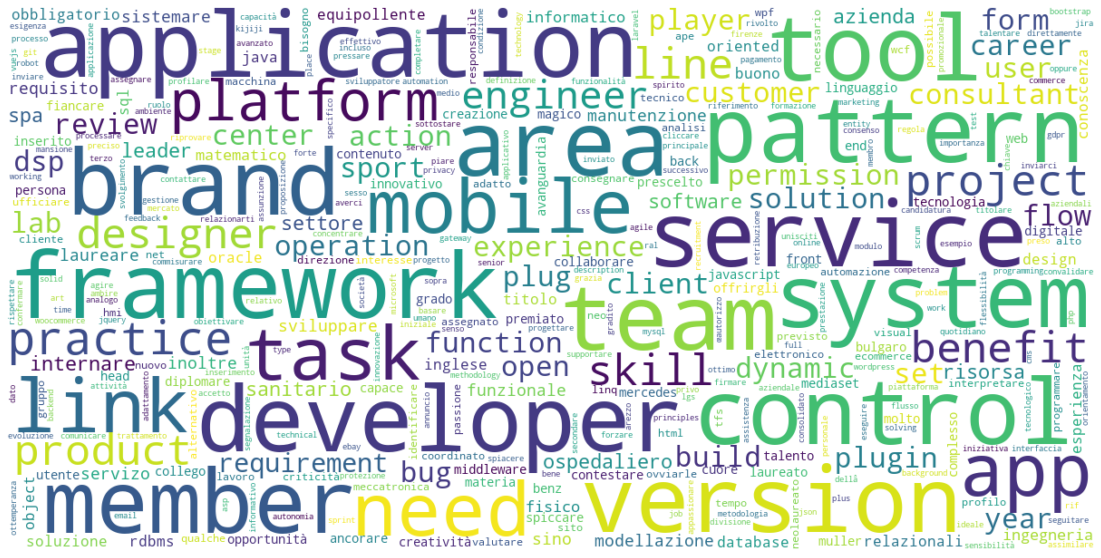

In [106]:
Word_Cloud(list(vectorizer.vocabulary_.items()))